In [2]:
import numpy as np
import gym
from IPython import display
import matplotlib.pyplot as plt
import time

MAP_DESIGN = [
    "SFFFFFFFH",
    "FFHHHHHFH",
    "FFHFFFFFH",
    "FFHFFHFFH",
    "FFHFFHFFH",
    "FFFFFHFFG",
]

# Deterministic and Stochastic behavior
deterministic = [
    [1, 0, 0, 0], # up
    [0, 1, 0, 0], # down
    [0, 0, 1, 0], # left
    [0, 0, 0, 1] # right
]

stochastic = [
    [1, 0, 0, 0], # up
    [0, 0.9, 0, 0.1], # down
    [0, 0, 1, 0], # left
    [0, 0, 0, 1] # right
]

# Reward Policy
rewards = {
    "S": -0.04,
    "F": -0.04,
    "H": -100,
    "G": 1
}

action_map = [3, 1, 0, 2]

In [3]:
# Actions in the enviornment
class Actions:
    def __init__(self, stochastic, rewards, env, states):
        self.stochastic = stochastic
        self.rewards = rewards
        self.env = env
        self.states = states

    def up(s):
        return (s[0]-1,s[1])
    def down(s):
        return (s[0]+1,s[1])
    def left(s):
        return (s[0],s[1]-1)
    def right(s):
        return (s[0],s[1]+1)
    
    actions = [up, down, left, right]

    def move(self, s, idx):
        acutal = np.random.choice(4, p=self.stochastic[idx])
        return (acutal, Actions.actions[acutal](s))

    def getRewards(self, s, idx):
        reward = 0
        for i in range(4):
            if self.stochastic[idx][i] == 0:
                continue
            next_state = Actions.actions[i](s)
            r_s = 0
            if self.states.inBounds(next_state):
                r_s = self.rewards[self.env[next_state[0]][next_state[1]]]
            else:
                r_s = -1
            reward += self.stochastic[idx][i]*r_s
        return reward

In [4]:
# States in the enviornment
class States:
    def __init__(self, w, h):
        self.w = w
        self.h = h
        self.goal = (w - 1, h - 1)

    def getStates(self):
        states = []
        for i in range(self.w):
            for j in range(self.h):
                states.append((i,j))
        return states
    
    def inBounds(self,s):
        if min(s) < 0 or s[0] >= self.w or s[1] >= self.h:
            return False
        else:
            return True

In [5]:
class Q_Agent:
    def __init__(self, env, actions: Actions, states_class: States, discount=0.95, lr=0.3, start=(0,0), eps_decay = 0.99, eps_min = 0.1, env_map = MAP_DESIGN, stochastic=False):
        self.gym_env = gym.make('FrozenLake-v1', render_mode='rgb_array', desc=env_map, is_slippery=stochastic)
        self.env = env
        self.actions = actions
        self.states_class = states_class
        self.states = self.states_class.getStates()
        self.start = start
        self.end = self.states_class.goal
        self.eps_min = eps_min
        self.eps_decay = eps_decay

        self.discount = discount
        self.lr = lr

        self.q = {}
        for state in self.states:
            self.q[state] = [-1]*4

    def train(self, episodes = 1000, disp = False, fre = 70, show_fre = 100):
        rewards_collected = []
        eps = 1
        img = None
        fell = False
        for episode in range(episodes):
            fell = False
            if disp and episode % show_fre == 0:
                self.gym_env.reset()
                img = plt.imshow(self.gym_env.render())
            reward = 0
            cur = (0,0)
            next = None
            max_steps = 10000
            step_num = 0
            action = 0
            actual = 0
            while cur != self.end and step_num < max_steps:
                step_num+=1
                if np.random.rand() < eps:
                    action = np.random.randint(0,4)
                else:
                    action = self.q[cur].index(max(self.q[cur]))
                (actual, next) = self.actions.move(cur, action)
                if not self.states_class.inBounds(next):
                    continue
                markov_sum = 0
                for i in range(4):
                    prob = self.actions.stochastic[action][i]
                    if prob == 0:
                        continue
                    pos_next = self.actions.actions[i](cur)
                    if self.states_class.inBounds(pos_next):
                        val = max(self.q[pos_next])
                    else:
                        val = -1
                    markov_sum += prob * val
                temporal_diff = self.actions.getRewards(cur,action) - self.q[cur][action] + self.discount * markov_sum
                self.q[cur][action] += self.lr * temporal_diff
                reward += self.actions.rewards[self.env[next[0]][next[1]]]
                cur = next
                if disp and (not fell) and episode % show_fre == 0:
                    img.set_data(self.gym_env.render()) # just update the data
                    display.display(plt.gcf())
                    display.clear_output(wait=True)
                    self.gym_env.step(action_map[actual])
                    time.sleep(0.1)
                if self.actions.rewards[self.env[next[0]][next[1]]] == self.actions.rewards["H"]:
                    fell = True
            if disp and episode % show_fre == 0:
                img.set_data(self.gym_env.render()) # just update the data
                display.display(plt.gcf())
                display.clear_output(wait=True)
                self.gym_env.step(action_map[actual])
                # time.sleep(0.1)
            rewards_collected.append(reward)
            if not disp and episode % fre == 0:
                print(f"Episode {episode}, rewards collected : {reward}")
            eps = max(self.eps_min, self.eps_decay*eps)
        return rewards_collected
    
    def solve(self):
        self.gym_env.reset()
        img = plt.imshow(self.gym_env.render())
        cur = self.start
        route = [cur]
        
        while cur != self.end:
            action = self.q[cur].index(max(self.q[cur]))
            (action, cur) = self.actions.move(cur, action)
            if self.actions.actions[action]:
                pass
            img.set_data(self.gym_env.render()) # just update the data
            display.display(plt.gcf())
            display.clear_output(wait=True)
            self.gym_env.step(action_map[action])
            route.append(cur)
            time.sleep(0.2)
        img.set_data(self.gym_env.render()) # just update the data
        display.display(plt.gcf())
        display.clear_output(wait=True)
        self.gym_env.step(action_map[action]) 

In [6]:
states_1 = States(len(MAP_DESIGN), len(MAP_DESIGN[0]))
action_1 = Actions(stochastic=deterministic, rewards=rewards, env=MAP_DESIGN, states=states_1)
model_1 = Q_Agent(env=MAP_DESIGN,actions=action_1,states_class=states_1,eps_decay=0.999,start=(0,0))

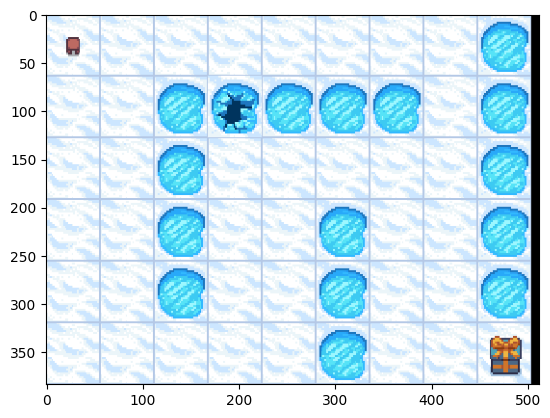

In [7]:
x = model_1.train(disp=True, fre=1000, show_fre=100)

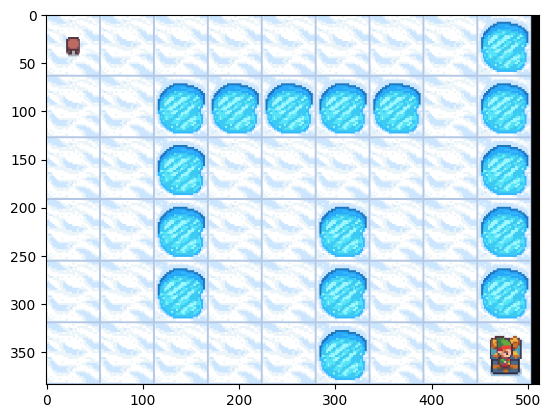

In [8]:
model_1.solve()

0.52
8


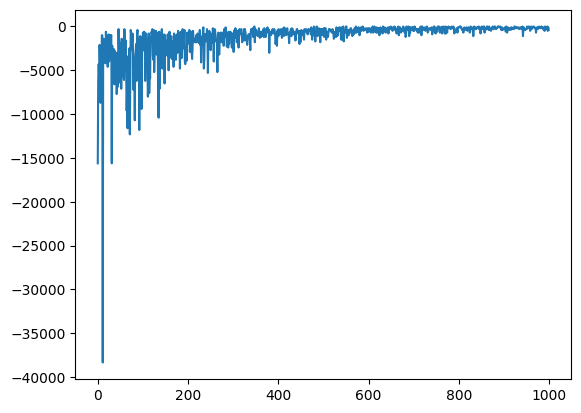

In [9]:
plt.plot(x)
print(max(x))
print(x.count(max(x)))

In [10]:
states_2 = States(len(MAP_DESIGN), len(MAP_DESIGN[0]))
action_2 = Actions(stochastic=stochastic, rewards=rewards, env=MAP_DESIGN, states=states_2)
model_2 = Q_Agent(env=MAP_DESIGN,actions=action_2,states_class=states_2, eps_decay=0.999, lr=0.1,start=(0,0))

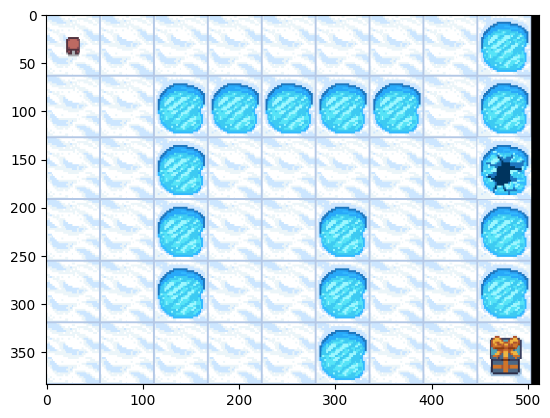

In [11]:
x = model_2.train(disp=True, fre=1000, show_fre=100)

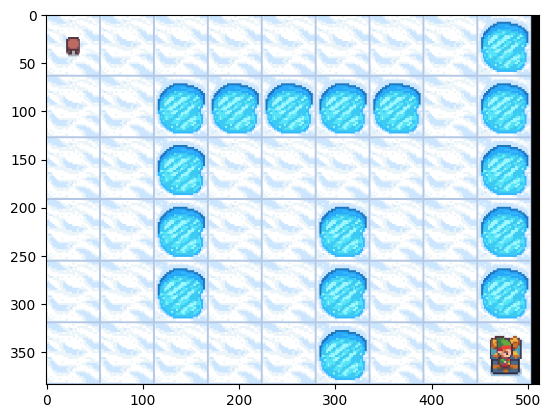

In [12]:
model_2.solve()

0.2799999999999999
1


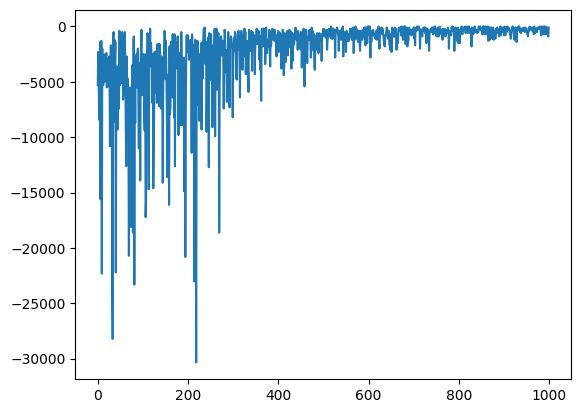

In [13]:
plt.plot(x)
print(max(x))
print(x.count(max(x)))